# **Projet : Analyse Statistique des Performances Académiques**
**Étudiant :** Aroud Mohamed Oussema

**Framework :** Data Science Workflow (Access, Pre-processing, Extract Insights, Produce Insight)

# 1. Introduction (Contexte de l'étude)
Cette étude porte sur un jeu de données provenant de **Kaggle** concernant les performances d'étudiants aux examens (Mathématiques, Lecture, Écriture).

**Objectif :** Identifier les facteurs socio-éducatifs qui influencent la réussite scolaire. Nous suivons une démarche scientifique pour transformer des données brutes en informations exploitables (Insights). Nous analyserons l'impact du genre, du type de repas et de la préparation aux tests.

# 2. Étape : Data Access (Importation)
 Cette première étape consiste à charger les bibliothèques nécessaires et à importer le fichier CSV. Nous utilisons *read_delim* avec une virgule pour garantir que le fichier est bien structuré en colonnes dès le départ.

In [2]:
library(tidyverse)
library(ggplot2)
library(dplyr)
install.packages("janitor") # Install the janitor package
library(janitor)
install.packages("xgboost") # Install the xgboost package
library(xgboost)

# Importation du fichier brut
raw_data <- read_delim("/content/exams.csv", delim = ",")
head(raw_data)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Installing package into ‘/usr/local/lib/R/site-library’
(as ‘lib’ is unspecified)

Rows: 1000 Columns: 8
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (5): gender, race/ethnicity, parental level of education, lunch, test pr...
dbl (3): math score, reading score, writing score

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


gender,race/ethnicity,parental level of education,lunch,test preparation course,math score,reading score,writing score
<chr>,<chr>,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>
male,group A,high school,standard,completed,67,67,63
female,group D,some high school,free/reduced,none,40,59,55
male,group E,some college,free/reduced,none,59,60,50
male,group B,high school,standard,none,77,78,68
male,group E,associate's degree,standard,completed,78,73,68
female,group D,high school,standard,none,63,77,76


# 3. Étape : Data Pre-Processing (Nettoyage)
 Le "Pre-processing" est crucial. Ici, nous nettoyons les noms des colonnes pour qu'ils soient exploitables sans espaces. Nous convertissons également les scores en variables numériques et créons une variable booléenne pour le cours de préparation afin de simplifier la modélisation.

In [3]:
data_clean <- raw_data %>%
  clean_names() %>%

  remove_empty(which = c("rows", "cols")) %>%
  drop_na() %>%
   mutate(
    across(contains("score"), as.numeric),
    test_prep_bool = if_else(test_preparation_course == "completed", TRUE, FALSE) )
view(data_clean)

# 4. Étape : Extract Insights - Statistiques Descriptives
Nous calculons ici la tendance centrale (moyenne, médiane) et la dispersion (variance). Cela nous permet d'avoir une première vue d'ensemble de la performance globale des étudiants.

In [4]:
# Calcul des statistiques pour le score de mathématiques
stats_result <- data_clean %>%
  summarise(
    Moyenne = mean(math_score),
    Mediane = median(math_score),
    Variance = var(math_score),
    Ecart_Type = sd(math_score)
  )

print(stats_result)

# A tibble: 1 × 4
  Moyenne Mediane Variance Ecart_Type
    <dbl>   <dbl>    <dbl>      <dbl>
1    66.4    66.5     237.       15.4


# 5. Étape : Explore Data - Test de Normalité
 Avant de choisir un test statistique, nous devons vérifier si les données suivent une loi normale. Nous utilisons un histogramme avec une courbe de densité pour l'aspect visuel, et le test de Shapiro-Wilk pour la confirmation mathématique.

Warning message:
“Using `size` aesthetic for lines was deprecated in ggplot2 3.4.0.
ℹ Please use `linewidth` instead.”


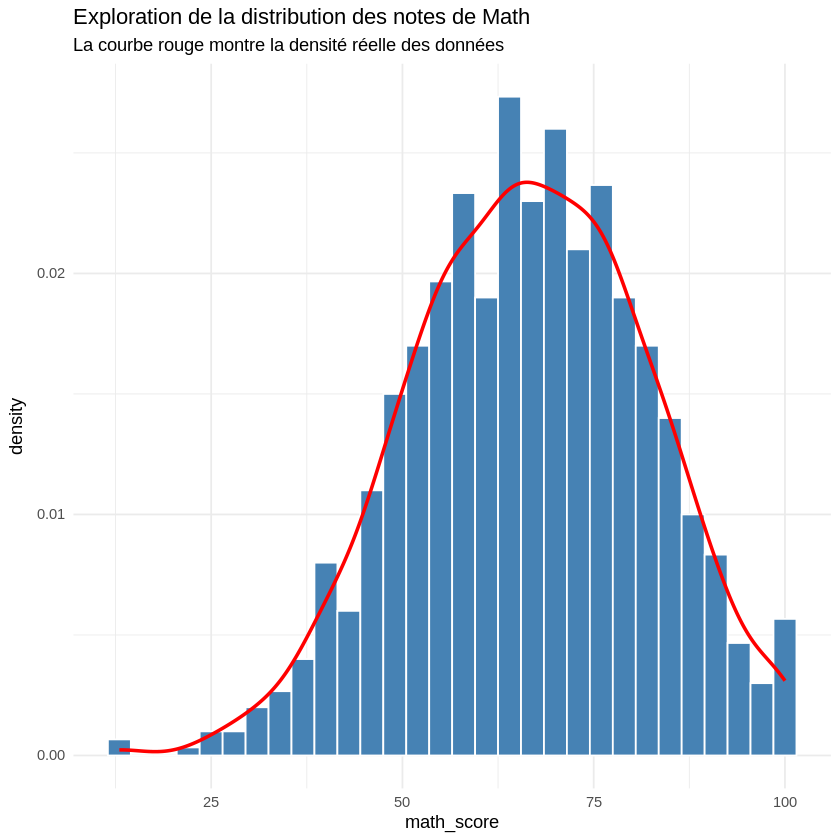

In [5]:
# Histogramme avec courbe de densité
ggplot(data_clean, aes(x = math_score)) +
  geom_histogram(aes(y = after_stat(density)), bins = 30, fill = "steelblue", color = "white") +
  geom_density(color = "red", size = 1) +
  labs(title = "Exploration de la distribution des notes de Math",
       subtitle = "La courbe rouge montre la densité réelle des données") +
  theme_minimal()

In [6]:
shapiro.test(data_clean$math_score)


	Shapiro-Wilk normality test

data:  data_clean$math_score
W = 0.99508, p-value = 0.002512


# 6. Étape : Model - Comparaison de Groupes (Test t)
 Nous cherchons à savoir si une variable catégorielle (comme le genre) a un impact réel sur la moyenne. Le Test t de Student compare les moyennes des deux groupes.


	Welch Two Sample t-test

data:  math_score by gender
t = -6.4663, df = 984.07, p-value = 1.579e-10
alternative hypothesis: true difference in means between group female and group male is not equal to 0
95 percent confidence interval:
 -8.066218 -4.310233
sample estimates:
mean in group female   mean in group male 
            63.19669             69.38491 



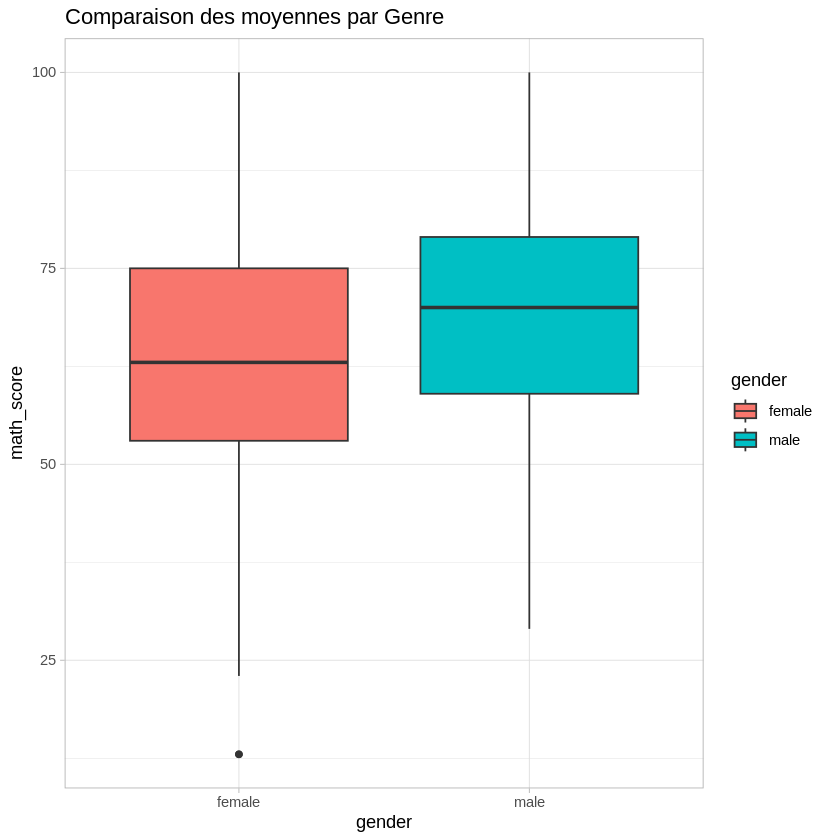

In [7]:
# Comparaison Gender vs Math Score
t_test_results <- t.test(math_score ~ gender, data = data_clean)
print(t_test_results)

# Visualisation pour l'insight
ggplot(data_clean, aes(x = gender, y = math_score, fill = gender)) +
  geom_boxplot() +
  labs(title = "Comparaison des moyennes par Genre") +
  theme_light()

# 7. Étape : Modélisation -
**7.1. Régression Linéaire (Statistique Classique)**

 Nous cherchons d'abord à comprendre la relation entre deux compétences liées : la lecture et l'écriture. La régression linéaire nous permet de modéliser cette relation par l'équation $Y = \beta_0 + \beta_1 X + \epsilon$.


Call:
lm(formula = writing_score ~ reading_score, data = data_clean)

Residuals:
     Min       1Q   Median       3Q      Max 
-12.7666  -3.3458   0.0753   3.3150  13.5701 

Coefficients:
              Estimate Std. Error t value Pr(>|t|)    
(Intercept)   -1.96796    0.70677  -2.784  0.00546 ** 
reading_score  1.01020    0.01002 100.848  < 2e-16 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Residual standard error: 4.666 on 998 degrees of freedom
Multiple R-squared:  0.9106,	Adjusted R-squared:  0.9106 
F-statistic: 1.017e+04 on 1 and 998 DF,  p-value: < 2.2e-16


`geom_smooth()` using formula = 'y ~ x'


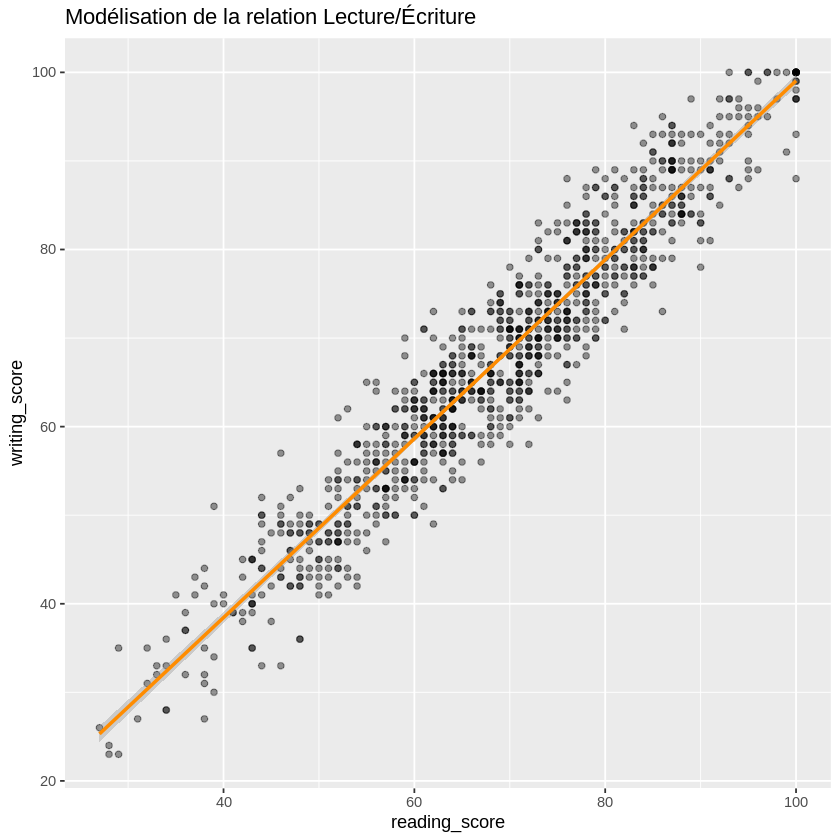

In [8]:
# Création du modèle de régression
regression_model <- lm(writing_score ~ reading_score, data = data_clean)
summary(regression_model)

# Visualisation de la corrélation
ggplot(data_clean, aes(x = reading_score, y = writing_score)) +
  geom_point(alpha = 0.4) +
  geom_smooth(method = "lm", color = "darkorange") +
  labs(title = "Modélisation de la relation Lecture/Écriture")

**7.2. Machine Learning avec XGBoost (Analyse Avancée)**

 Après la statistique descriptive, nous utilisons un algorithme de Gradient Boosting (XGBoost) pour prédire la note de mathématiques. L'intérêt majeur ici est d'extraire l'importance des variables ("Feature Importance") pour voir quel facteur (genre, repas, préparation) influence le plus le score.

Warning message in throw_err_or_depr_msg("Passed unrecognized parameters: ", paste(head(names_unrecognized), :
“Passed unrecognized parameters: silent. This warning will become an error in a future version.”


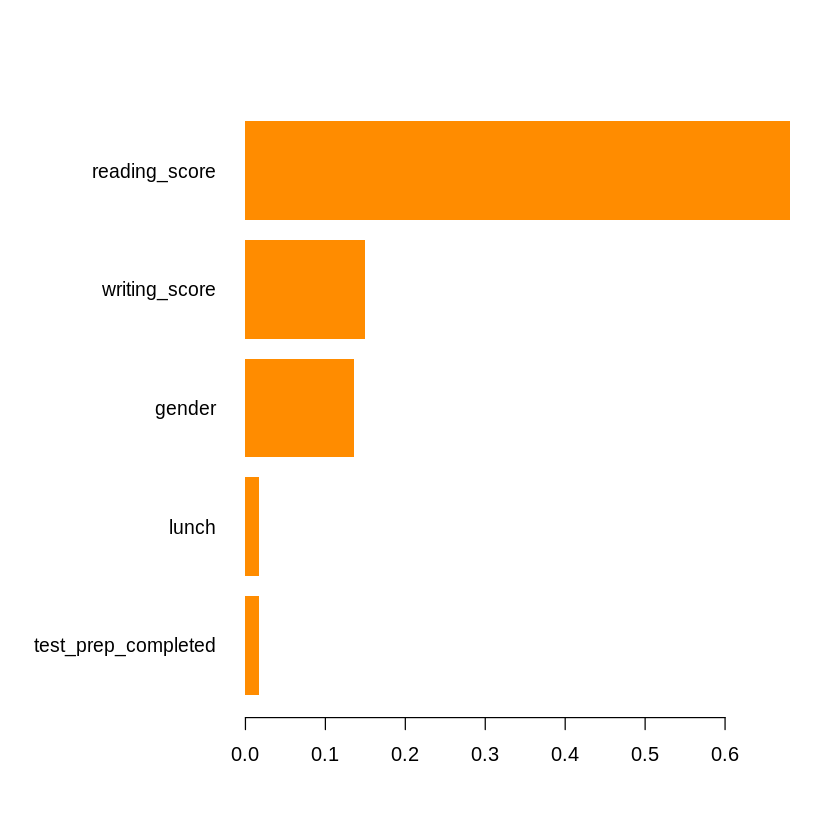

In [10]:
data_xgb <- data_clean %>%
  mutate(
    gender = if_else(gender == "female", 1, 0),
    lunch = if_else(lunch == "standard", 1, 0),
    test_prep_completed = if_else(test_preparation_course == "completed", 1, 0)
  ) %>%
  select(gender, lunch, test_prep_completed, reading_score, writing_score, math_score)

# Séparation des caractéristiques (X) et de la cible (y : math_score)
X <- as.matrix(data_xgb %>% select(-math_score))
y <- data_xgb$math_score

# 3. Entraînement du modèle (Model) - Mise à jour des arguments
model_xgb <- xgboost(x = X, y = y, nrounds = 50, objective = "reg:squarederror", verbose = 0)

# 4. Importance des variables (Extract Insights)
importance_matrix <- xgb.importance(feature_names = colnames(X), model = model_xgb)
xgb.plot.importance(importance_matrix, col = "darkorange")

# 8. Étape : Synthèse et Insight Majeur (Produce Insight)
 La dernière étape du workflow consiste à communiquer les résultats de manière visuelle et percutante. Ici, nous agrégeons les données pour comparer l'impact réel du cours de préparation sur les trois matières. Le passage au format "long" *(pivot_longer)* permet de créer un graphique comparatif clair.

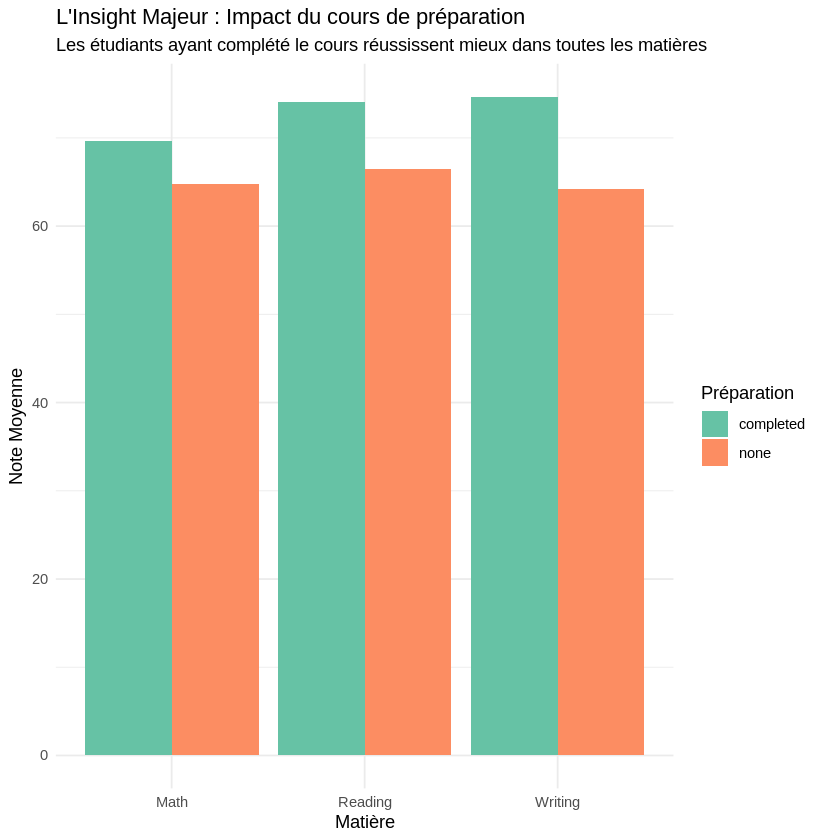

In [11]:
final_summary <- data_clean %>%
  group_by(test_preparation_course) %>%
  summarise(
    Math = mean(math_score),
    Reading = mean(reading_score),
    Writing = mean(writing_score)
  ) %>%
  pivot_longer(cols = -test_preparation_course, names_to = "Subject", values_to = "Average_Score")

ggplot(final_summary, aes(x = Subject, y = Average_Score, fill = test_preparation_course)) +
  geom_bar(stat = "identity", position = "dodge") +
  theme_minimal() +
  scale_fill_brewer(palette = "Set2") +
  labs(title = "L'Insight Majeur : Impact du cours de préparation",
       subtitle = "Les étudiants ayant complété le cours réussissent mieux dans toutes les matières",
       y = "Note Moyenne", x = "Matière",fill="Préparation")

# 9. Produce Insight (Conclusion)
La dernière étape consiste à synthétiser les découvertes. C'est ici que nous répondons à la problématique initiale.

**Conclusions majeures :**



**1.   Facteurs Clés:**
Le cours de préparation et le type de repas sont des indicateurs forts de réussite.

**2.   Corrélations:**
Les compétences en lecture et en écriture sont extrêmement liées (R² élevé).

**3.   Modélisation :**
Le modèle XGBoost confirme que les scores littéraires sont les meilleurs prédicteurs des scores scientifiques dans ce dataset.